In [1]:
%matplotlib notebook

import PyLidar3
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import threading
import time
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


In [2]:
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Elapsed time for {func.__name__}: {end - start:.6f} seconds")
        return result
    return wrapper

In [3]:
def init_kalman_filter():
    kf = KalmanFilter(dim_x=6, dim_z=3)
    
    kf.F = np.array([[1, 0, 0, 1, 0, 0],
                     [0, 1, 0, 0, 1, 0],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])
    
    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0]])
    
    kf.R *= 10  # Measurement noise
    q = Q_discrete_white_noise(dim=3, dt=1, var=0.1)
    kf.Q[0:3, 0:3] = q
    kf.Q[3:6, 3:6] = q
    
    kf.P *= 100  # Initial uncertainty
    
    return kf


In [4]:
def get_clusters(clusterOp_data):
    cluster_n = []  # initialize empty list for first cluster
    clusters = []  # initialize list to hold all clusters

    for value in clusterOp_data:
        if value == 720:
            if cluster_n:  # check if cluster_n already has values
                clusters.append(cluster_n)  # if so, add it to clusters
                cluster_n = []  # reset cluster_n to empty list
        else:
            cluster_n.append(value)  # add value to current cluster

    if cluster_n:  # handle the last cluster after the loop ends
        clusters.append(cluster_n)

    return clusters

In [5]:
#@timed
def collect_data():
    gen = Obj.StartScanning()
    data = next(gen)
    distance = []
    for points in data:
        distance.append(data[points])
    Obj.StopScanning()
    return distance

In [6]:
#@timed
def process_data(distance):
    input_buffer = allocate(shape=(360,), dtype=np.int32)
    np.copyto(input_buffer, distance)
    output_buffer = allocate(shape=(380,), dtype=np.int32)

    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()

    clusterOp_data = []
    for x in output_buffer:
        if x != 0 or output_buffer.tolist().count(x) == 1:
            clusterOp_data.append(x)

    del input_buffer, output_buffer

    clusters = get_clusters(clusterOp_data)
    return clusters

In [7]:
def find_centroids(clusters, distance):
    centroids = []
    
    for cluster in clusters:
        cluster_size = len(cluster)
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        
        centroid_distance = np.mean(clusterDistance)
        centroid_angle = np.mean(clusterTheta)
        
        centroids.append((centroid_angle, centroid_distance, cluster_size))
    
    return centroids

In [8]:
def update_plot(ax1, ax2, distance, clusters, master_list=[], prev_master_list=[]):
    ax1.clear()
    ax1.scatter(np.deg2rad(angle), distance, s=5)
    ax1.set_title("Raw Data")
    ax1.set_ylim(0, max(distance))

    ax2.clear()
    for cluster in clusters:
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        try:
            ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)
        except Exception as e:
            print('\033[31m' +str(clusterTheta) + '\033[0m')

    # Removed the code that plots centroids

    color_idx = 0
    for master_cluster in master_list:
        angle1 = master_cluster['Angle']
        distance1 = master_cluster['Distance']
        size = master_cluster['Size']
        cluster_id = master_cluster['ID']
        color = f'C{cluster_id % 10}'
        ax2.scatter(np.deg2rad(angle1), distance1, s=50, marker='x', c=color)
        color_idx += 1

    ax2.set_title("Clustered Data with Kalman Filter")
    ax2.set_ylim(0, max(distance))

In [9]:
def match_clusters(curr_centroids, master_list, threshold_distance):
    matches = []
    curr_matched = []
    master_scores = []
    for i, master_cluster in enumerate(master_list):
        min_score = float('inf')
        matched_cluster = None
        for j, curr_cluster in enumerate(curr_centroids):
            if j in curr_matched:
                continue
                
            delta_angle = abs(curr_cluster[0] - master_cluster['Angle'])
            delta_distance = abs(curr_cluster[1] - master_cluster['Distance'])
            prev_distance = master_cluster['Distance']
            delta_size = abs(curr_cluster[2] - master_cluster['Size'])
            
            if delta_distance > threshold_distance:
                continue
            
            polar_euclidean_distance = np.sqrt(delta_distance ** 2 + prev_distance ** 2 - 2 * delta_distance * prev_distance * np.cos(delta_angle))
            score = delta_size * (delta_angle * 10) * delta_distance
            
            if score < min_score:
                min_score = score
                delta_polar_distance = polar_euclidean_distance
                matched_cluster = (j, curr_cluster, score)
        
        if matched_cluster:
            matches.append((i, *matched_cluster))
            curr_matched.append(matched_cluster[0])
            master_scores.append(matched_cluster[2])
        
    # Assign new ID to current clusters not matched to any cluster in the master list
    for j, curr_cluster in enumerate(curr_centroids):
        if j not in curr_matched:
            cluster_id = len(master_list)
            master_list.append({'ID': cluster_id, 'Angle': curr_cluster[0], 'Distance': curr_cluster[1], 'Size': curr_cluster[2]})
        
    # Remove excess clusters from master_list if there are more clusters in master_list than in curr_centroids
    if len(curr_centroids) < len(master_list):
        num_clusters_to_remove = len(master_list) - len(curr_centroids)
        for i in range(num_clusters_to_remove):
            max_score_index = np.argmax(master_scores)
            master_scores.pop(max_score_index)
            master_list.pop(max_score_index)
    
    # Update the matched clusters in master_list
    new_master_list = []
    for match in matches:
        prev_index, curr_index, curr_cluster, score = match
        cluster_id = master_list[prev_index]['ID']
        kf = master_list[prev_index]['KF']
    
        kf.predict()
        kf.update(np.array(curr_cluster))
    
        new_master_list.append({'ID': cluster_id, 'Angle': kf.x[0],'Distance': kf.x[1], 'Size': kf.x[2], 'KF': kf})
        
        #print(f"Kalman Filter for cluster ID {cluster_id}:")
        #print(kf)

    
    return new_master_list


In [10]:
angle = np.arange(0, 360)
port = "/dev/ttyUSB0"  # linux
Obj = PyLidar3.YdLidarX4(port, 12000)

if Obj.Connect():
    print(Obj.GetDeviceInfo())
else:
    print("Error connecting to device")
    exit(1)

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp2/clusterOp2.bit')
ol.clusterOp2_0.register_map
CONTROL_REGISTER = 0x0
ol.clusterOp2_0.write(CONTROL_REGISTER, 0x81)  # 0x81 will set bit 0
dma = ol.axi_dma

{'model_number': '6', 'firmware_version': '1.5', 'hardware_version': '1', 'serial_number': '201904120'}


<IPython.core.display.Javascript object>


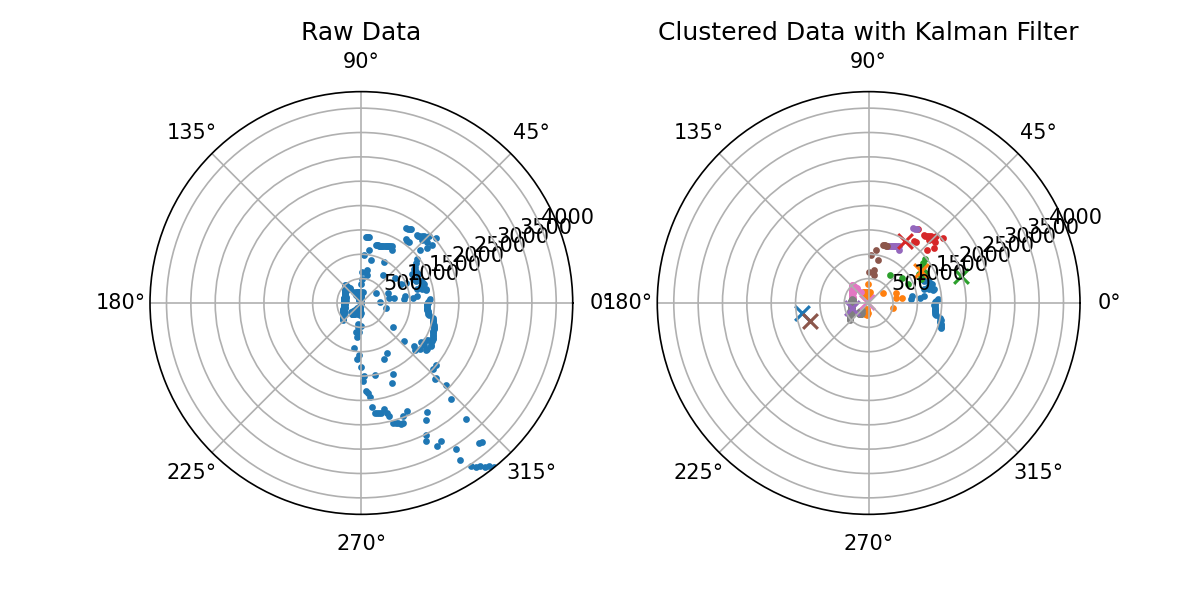

Iteration 1
Elapsed time for iteration 1: 3.504420 seconds
Iteration 2
Elapsed time for iteration 2: 4.040285 seconds
Iteration 3
Elapsed time for iteration 3: 4.050532 seconds
Iteration 4
Elapsed time for iteration 4: 4.056009 seconds
Iteration 5
Elapsed time for iteration 5: 4.098914 seconds
Iteration 6
Elapsed time for iteration 6: 4.110353 seconds
Iteration 7
Elapsed time for iteration 7: 4.099614 seconds
Done!


In [11]:
iterations = 7

master_list = []
prev_centroids = []

# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(projection='polar'))
plt.ion()

for i in range(iterations):
    start_time = time.time()
    print(f"Iteration {i + 1}")

    distance = collect_data()
    clusters = process_data(distance)
    curr_centroids = find_centroids(clusters, distance)

    if i == 0:
        for j, centroid in enumerate(curr_centroids):
            cluster_id = j
            kf = init_kalman_filter()
            kf.x[:3] = np.array(centroid).reshape(-1, 1)
            master_list.append({'ID': cluster_id, 'Angle': centroid[0], 'Distance': centroid[1], 'Size': centroid[2], 'KF': kf})
    else:
        # Match current clusters to previous clusters using master_list
        master_list = match_clusters(curr_centroids, master_list, threshold_distance=10000)

        update_plot(ax1, ax2, distance, clusters, master_list=master_list, prev_master_list=prev_master_list)


    prev_centroids = curr_centroids
    prev_master_list = master_list.copy()

    end_time = time.time()
    print(f"Elapsed time for iteration {i + 1}: {end_time - start_time:.6f} seconds")

print("Done!")
Obj.Disconnect()
